In [1]:
import numpy as np
import pandas as pd
import math
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader
import random  
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
mm_x= MinMaxScaler()
data = pd.read_csv(r'data_F_0928-lvbo-zb3.0.csv')
customer_list = list(set(data['N_customer']))
data_features = data.iloc[:,[3,4,7,8]]

data_features = np.array(data_features)
data_features = mm_x.fit_transform(data_features)
data_features = pd.DataFrame(data_features,columns=['x','y','v','d'])
z_dataset = pd.concat([data, data_features], axis=1, join='outer')
mm_x1= MinMaxScaler()
x1 = mm_x1.fit_transform(data.iloc[:,[3,4]])

customer_list_train = customer_list[:int(len(customer_list)*0.7)]
customer_list_test = customer_list[int(len(customer_list)*0.7):]

dataset_lenth = 15000
windows = 3
dataset_train_lenth = 0.8*dataset_lenth
dataset_train_windows = windows + 1
n_times = 2

def collection_data(dataset,lenth,amounts,n):
    collection_data_list = []
    count = 0 
    count_list = []    
    count_amounts = 0
    for i in range(len(dataset)-lenth):
        loopcount = 0
        for j in range(lenth):
            variable_i = i + n*j
            loopcount += 1
            if variable_i < (len(dataset)-n):                 
                if dataset.iloc[variable_i+n,2] - dataset.iloc[variable_i,2] ==n:

                    count_list.append(list(dataset.iloc[variable_i,[9,10,11,12]]))           
                    count += 1
        if loopcount == lenth:
            if count < lenth:                        
                count_list = []
                count = 0                    
        if count == lenth:
            collection_data_list.append(count_list)
            count = 0
            count_list = []
            count_amounts += 1
        if count_amounts == amounts:
            break
    return collection_data_list
 
train_dataset = z_dataset[z_dataset['N_customer'].isin(customer_list_train)]
train_dataset = train_dataset.reset_index(drop=True)
List_train_dataset = collection_data(train_dataset,dataset_train_windows,dataset_train_lenth,n_times)


#定义保存路径
filename = filename = '\\HRN\\' 
target_path = os.getcwd()   # 目标路径
b = target_path + filename  # 目标文件夹
if not os.path.exists(b):   # 判断目标路径下是否包含目标文件夹
    os.makedirs(b)     # 没有则新建该文件夹
    
#训练数据集
train_ratio = 0.875
validation_ratio = 0.125
split_point = int(len(List_train_dataset) * train_ratio)
dataset_train_list = np.array(List_train_dataset)
print('dataset_train_list',dataset_train_list.shape)
amount_of_features = dataset_train_list.shape[2]
print('amount_of_features',amount_of_features)
dataset_train_input = dataset_train_list[:split_point,:windows,:]
dataset_train_output = dataset_train_list[:split_point,windows,:]
print('dataset_train_input',dataset_train_input.shape)
dataset_train_output = np.reshape(dataset_train_output,(-1,1,amount_of_features))
dataset_train_output = dataset_train_output[:split_point,:,[0,1]]

print('dataset_train_output',dataset_train_output.shape)

dataset_val_input = dataset_train_list[split_point:,:windows,:]
dataset_val_output = dataset_train_list[split_point:,windows,:]
print('dataset_val_input',dataset_val_input.shape)
dataset_val_output = np.reshape(dataset_val_output,(-1,1,amount_of_features))
dataset_val_output = dataset_val_output[:split_point,:,[0,1]]

print('dataset_val_output',dataset_val_output.shape)

dataset_train_list (12000, 4, 4)
amount_of_features 4
dataset_train_input (10500, 3, 4)
dataset_train_output (10500, 1, 2)
dataset_val_input (1500, 3, 4)
dataset_val_output (1500, 1, 2)


In [2]:
#测试集
dataset_test_lenth = 0.2*dataset_lenth  #测试集长度
dataset_test_windows = windows + 1
test_dataset = z_dataset[z_dataset['N_customer'].isin(customer_list_test)]
test_dataset = test_dataset.reset_index(drop=True)
List_test_dataset = collection_data(test_dataset,dataset_test_windows,dataset_test_lenth,n_times)

dataset_test_list = np.array(List_test_dataset)
print('dataset_test_list',dataset_test_list.shape)

dataset_test_input = dataset_test_list[:,:windows,:]
dataset_test_output = dataset_test_list[:,windows:,:]
print('dataset_test_input',dataset_test_input.shape)
dataset_test_output = np.reshape(dataset_test_output,(-1,amount_of_features))
dataset_test_output = dataset_test_output[:,[0,1]]
dataset_test_output = np.reshape(dataset_test_output,(-1,1,2))
print('dataset_test_output',dataset_test_output.shape)

dataset_test_list (3000, 4, 4)
dataset_test_input (3000, 3, 4)
dataset_test_output (3000, 1, 2)


In [3]:
%matplotlib inline

import time
import math
import random
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
class HybridCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(HybridCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input_ih_1 = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.input_hh_1 = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.input_ch_1 = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.input_bias_ih_1 = nn.Parameter(torch.Tensor(hidden_size))
        self.input_bias_hh_1 = nn.Parameter(torch.Tensor(hidden_size))
        self.input_bias_ch_1 = nn.Parameter(torch.Tensor(hidden_size))

        self.input_ih_2 = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.input_hh_2 = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.input_bias_ih_2 = nn.Parameter(torch.Tensor(hidden_size))
        self.input_bias_hh_2 = nn.Parameter(torch.Tensor(hidden_size))

        self.forget_ih = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.forget_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.forget_ch = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.forget_bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.forget_bias_hh = nn.Parameter(torch.Tensor(hidden_size))
        self.forget_bias_ch = nn.Parameter(torch.Tensor(hidden_size))

        self.cell_ih = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.cell_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.cell_ch = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.cell_bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.cell_bias_hh = nn.Parameter(torch.Tensor(hidden_size))
        self.cell_bias_ch = nn.Parameter(torch.Tensor(hidden_size))

        self.output_ih = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.output_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.output_bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.output_bias_hh = nn.Parameter(torch.Tensor(hidden_size))
        
        self.key_ih = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.key_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.key_bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.key_bias_hh = nn.Parameter(torch.Tensor(hidden_size))

        self.GRU_output_ih = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.GRU_output_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.GRU_output_ch = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.GRU_output_bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.GRU_output_bias_hh = nn.Parameter(torch.Tensor(hidden_size))
        self.GRU_output_bias_ch = nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_parameters()

    def init_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for param in self.parameters():
            nn.init.uniform_(param, -stdv, stdv)

    def forward(self, x, init_states, h_t_1):
        x = x.to(torch.float32)
        h_t_minus_1, c_t_minus_1 = init_states
        inputgate_1 = (torch.mm(x, self.input_ih_1) + self.input_bias_ih_1) + (torch.mm(h_t_minus_1, self.input_hh_1) + self.input_bias_hh_1)+ (torch.mm(c_t_minus_1, self.input_ch_1) + self.input_bias_ch_1)
        
        inputgate_2 = (torch.mm(x, self.input_ih_2) + self.input_bias_ih_2) + (torch.mm(h_t_minus_1, self.input_hh_2) + self.input_bias_hh_2)

        forgetgate = (torch.mm(x, self.forget_ih) + self.forget_bias_ih) + (torch.mm(h_t_minus_1, self.forget_hh) + self.forget_bias_hh)+ (torch.mm(c_t_minus_1, self.forget_ch) + self.forget_bias_ch)
        
        cell = (torch.mm(x, self.cell_ih) + self.cell_bias_ih) + (torch.mm(h_t_minus_1, self.cell_hh) + self.cell_bias_hh)+ (torch.mm(c_t_minus_1, self.cell_ch) + self.cell_bias_ch)
        
        outputgate = (torch.mm(x, self.output_ih) + self.output_bias_ih) + (torch.mm(h_t_minus_1, self.output_hh) + self.output_bias_hh)
        
        c = (torch.sigmoid(forgetgate) * c_t_minus_1) + (torch.sigmoid(inputgate_1) * torch.tanh(inputgate_2))

        h_LSTM = torch.sigmoid(outputgate) * torch.tanh(c)
         
        key_gate = (torch.mm(x, self.key_ih) + self.key_bias_ih) + (torch.mm(h_t_1, self.key_hh) + self.key_bias_hh)
        key_gate = torch.sigmoid(key_gate)

        output_gate = torch.tanh((torch.mm(x, self.GRU_output_ih)+self.GRU_output_bias_ih) + (torch.mm(key_gate,self.GRU_output_hh) +  self.GRU_output_bias_hh)+ (torch.mm(h_t_1, self.GRU_output_ch)+self.GRU_output_bias_ch))

        h_GRU = (1-key_gate) * h_t_minus_1 + key_gate* output_gate
        
        h = h_LSTM + h_GRU
        
        return (h, c), h_GRU


class Hybrid(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=True):
        super(Hybrid, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        layers = [HybridCell(input_size, hidden_size)]
        for i in range(num_layers - 1):
            layers += [HybridCell(hidden_size, hidden_size)]
        self.net = nn.Sequential(*layers)
        
    def forward(self, x, init_states=None):
        # Input and output size: (seq_length, batch_size, input_size)
        # States size: (num_layers, batch_size, hidden_size)
        if self.batch_first:
            x = x.transpose(0, 1)
        """LSTM-J"""
        self.h = torch.zeros(x.size(0), self.num_layers, x.size(1), self.hidden_size).to(x.device)
        self.c = torch.zeros(x.size(0), self.num_layers, x.size(1), self.hidden_size).to(x.device)
        self.h_G = torch.zeros(x.size(0), self.num_layers, x.size(1), self.hidden_size).to(x.device)
        
        if init_states is not None:
            self.h[0], self.c[0], self.h_G[0] = init_states

        inputs = x
        for i, cell in enumerate(self.net): 
            h_t, c_t, h_G_t= self.h[0, i].clone(), self.c[0, i].clone(), self.h_G[0, i].clone()
            for t in range(x.size(0)):
                (h_t, c_t), h_G_t = cell(inputs[t], (h_t, c_t), h_G_t)

                self.h[t, i], self.c[t, i], self.h_G[t, i] = h_t, c_t, h_G_t
            inputs = self.h[:, i].clone()+self.h_G[:, i].clone()
                
        if self.batch_first:
            return self.h[:, -1].transpose(0, 1), (self.h[-1], self.c[-1]), self.h_G[:, -1].transpose(0, 1), self.h_G[-1]
        
        return self.h[:, -1], (self.h[-1], self.c[-1]),self.h_G[:, -1], self.h_G[-1]
    
def softmax_weighted_sum(tensor1, tensor2):
    exp_tensor1 = torch.exp(tensor1)
    exp_tensor2 = torch.exp(tensor2)

    sum_tensor1 = torch.sum(exp_tensor1, dim=1, keepdim=True)
    sum_tensor2 = torch.sum(exp_tensor2, dim=1, keepdim=True)

    softmax_tensor1 = exp_tensor1 / sum_tensor1
    softmax_tensor2 = exp_tensor2 / sum_tensor2

    weighted_sum_tensor = softmax_tensor1 + softmax_tensor2

    return weighted_sum_tensor
    
class HybridModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(HybridModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.hybrid = Hybrid(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
    
    def forward(self, x):
        out_L, _,out_G, __ = self.hybrid(x, None)
        out = torch.tanh(torch.cat([out_L,out_G],-1))
        out = self.fc(out[:, -1, :]).unsqueeze(1)
        return out
    
class MyDataset(Dataset):
    def __init__(self, input,tgt):
        self.input = input
        self.tgt = tgt


    def __getitem__(self, index):

        return self.input[index], self.tgt[index]

    def __len__(self):
        return self.input.shape[0]
    
def adjust_learning_rate(epoch):

    lr = 0.01

    if epoch > 180:
        lr = lr / 2
    elif epoch > 150:
        lr = lr / 2
    elif epoch > 120:
        lr = lr / 2
    elif epoch > 90:
        lr = lr / 2
    elif epoch > 60:
        lr = lr / 2
    elif epoch > 30:
        lr = lr / 2

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
import torch.nn.functional as F        
class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()

    def forward(self, log_pred, log_actual):
        return torch.sqrt(F.mse_loss(log_pred, log_actual))
loss_fn_rmsle = RMSLELoss()

In [8]:
learning_rate = 0.01
num_epochs = 200
batch_size = 128

num_layers = 1
input_size = 4
hidden_size = 16
output_size = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_dataset = MyDataset(dataset_train_input,dataset_train_output)
val_dataset = MyDataset(dataset_val_input,dataset_val_output)
test_dataset = MyDataset(dataset_test_input,dataset_test_output)
train_loader = DataLoader(train_dataset,batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = HybridModel(input_size, hidden_size, num_layers, output_size)
print(model)

HybridModel(
  (hybrid): Hybrid(
    (net): Sequential(
      (0): HybridCell()
    )
  )
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


Epoch 0, Train loss 0.16220994293689728, val loss 0.04920279894052539
Epoch 1, Train loss 0.03236681967973709, val loss 0.02786353988000712
Epoch 2, Train loss 0.02408953383564949, val loss 0.023396142248330934
Epoch 3, Train loss 0.021353721618652344, val loss 0.020193381603211207
Epoch 4, Train loss 0.02114211767911911, val loss 0.020979393378087508
Epoch 5, Train loss 0.0180028285831213, val loss 0.024670460472425656
Epoch 6, Train loss 0.022904714569449425, val loss 0.018018615023608384
Epoch 7, Train loss 0.016333993524312973, val loss 0.02071405364110999
Epoch 8, Train loss 0.018766110762953758, val loss 0.019279699891489036
Epoch 9, Train loss 0.01535242609679699, val loss 0.024169273269535965
Epoch 10, Train loss 0.018595069646835327, val loss 0.022451144730883322
Epoch 11, Train loss 0.018423115834593773, val loss 0.01857865392002828
Epoch 12, Train loss 0.015118077397346497, val loss 0.021125916256001038
Epoch 13, Train loss 0.017151715233922005, val loss 0.013750159199990675

Epoch 113, Train loss 0.010504667647182941, val loss 0.010579888766130315
Epoch 114, Train loss 0.010629438795149326, val loss 0.009904018051783939
Epoch 115, Train loss 0.010446794331073761, val loss 0.010533456692970311
Epoch 116, Train loss 0.010727325454354286, val loss 0.00986750260495173
Epoch 117, Train loss 0.010405417531728745, val loss 0.00983090052841293
Epoch 118, Train loss 0.0104323485866189, val loss 0.00998411232752708
Epoch 119, Train loss 0.010426722466945648, val loss 0.010479178653019743
Epoch 120, Train loss 0.010588619858026505, val loss 0.009931902158324258
Epoch 121, Train loss 0.010659436695277691, val loss 0.00988239593067865
Epoch 122, Train loss 0.010441256687045097, val loss 0.010931030752083076
Epoch 123, Train loss 0.01041041687130928, val loss 0.012113617261369466
Epoch 124, Train loss 0.010597487911581993, val loss 0.011130962997891338
Epoch 125, Train loss 0.010450540110468864, val loss 0.010900696300242464
Epoch 126, Train loss 0.01042216643691063, va

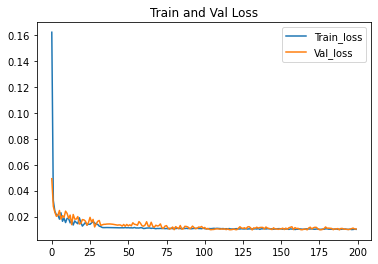

In [9]:
def test(model,dataloader):
    model.eval()
    total_loss = 0
    # loss_fn = torch.nn.MSELoss()
    loss_fn = loss_fn_rmsle
    # loss_fn = torch.nn.L1Loss(reduction='mean')
    with torch.no_grad():
        for i,batch in enumerate(dataloader):
            input,tgt = batch[0],batch[1]
            result = model(input)
            loss = loss_fn(result,tgt)
            total_loss += loss
    return (total_loss/len(dataloader))
def train(model,train_dataloader,test_dataloader,num_epoch):
    train_loss_coll = []
    val_loss_coll = []
    min_loss = 1000
    loss_fn = loss_fn_rmsle
    #loss_fn = torch.nn.SmoothL1Loss()
    # loss_fn = torch.nn.L1Loss(reduction='mean')
    for epoch in range(num_epoch):
        model = model.to(torch.float32)
        model.train()
        train_loss = 0

        for i,batch in enumerate(train_dataloader):
            input,tgt = batch[0],batch[1]
            input = input.to(torch.float32)
            #print(input.type())
            tgt = tgt.to(torch.float32)
            optimizer.zero_grad()
            result = model(input)
            loss = loss_fn(result,tgt)
            loss.backward()
            optimizer.step()

            train_loss+=loss

        adjust_learning_rate(epoch)
        train_loss = train_loss/len(train_dataloader)
        test_loss = test(model,test_dataloader)
        torch.save(model,'best_HYB.pt')

        train_loss_coll.append(train_loss)
        val_loss_coll.append(test_loss)

        print("Epoch {}, Train loss {}, val loss {}".format(epoch,train_loss,test_loss))

    return train_loss_coll, val_loss_coll

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
train_loss, val_loss = train(model, train_loader, val_loader, num_epochs)
epochs_range = range(len(train_loss))
plt.plot(epochs_range,train_loss,label= "Train_loss")
plt.plot(epochs_range, val_loss, label="Val_loss")
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

In [ ]:
def test(model,dataloader):
    model.eval()
    total_loss = 0
    # loss_fn = torch.nn.MSELoss()
    loss_fn = loss_fn_rmsle
    # loss_fn = torch.nn.L1Loss(reduction='mean')
    with torch.no_grad():
        for i,batch in enumerate(dataloader):
            input,tgt = batch[0],batch[1]
            result = model(input)
            loss = loss_fn(result,tgt)
            total_loss += loss

    return (total_loss/len(dataloader))
def predict(model,test_dataloader,mm_x):
    model.eval()
    results = []
    tgts=[]
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            input, tgt = batch[0], batch[1]
            result = model(input)
            tgts.extend(tgt)
            results.extend(result)

    tgts = torch.tensor([item.numpy() for item in tgts])

    results = torch.tensor([item.numpy() for item in results])
    tgts_inv = mm_x1.inverse_transform(tgts.reshape(-1,2))
    results_inv = mm_x1.inverse_transform(results.reshape(-1,2))

    return tgts_inv,results_inv
#评价函数
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

def mape(y_true, y_pred):
    """
    参数:
    y_true -- 测试集目标真实值
    y_pred -- 测试集目标预测值
    
    返回:
    mape -- MAPE 评价指标
    """
    
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

def easy_result(y_train, y_train_predict, train_index, model_index, col_index):
  #画图进行展示
  plt.figure(figsize=(10,5))
  plt.plot(y_train[:])
  plt.plot(y_train_predict[:])
  plt.legend(('real', 'predict'),fontsize='15')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()
  print('\n')

  plot_begin,plot_end=min(min(y_train),min(y_train_predict)),max(max(y_train),max(y_train_predict))
  plot_x=np.linspace(plot_begin,plot_end,10)
  plt.figure(figsize=(5,5))
  plt.plot(plot_x,plot_x)
  plt.plot(y_train,y_train_predict,'o')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()

  #输出结果
  print('%s上的MAE/RMSE/MAPE/R^2'%train_index)
  print(mean_absolute_error(y_train, y_train_predict))
  print(np.sqrt(mean_squared_error(y_train, y_train_predict) ))
  print(mape(y_train, y_train_predict) )
  print(r2_score(y_train, y_train_predict))

  pred_data = np.vstack([y_train, y_train_predict])
  pred_data = pd.DataFrame(pred_data).T
  pred_data.to_csv('Result_%s_%s_%s_HYB.csv'%(model_index ,train_index, col_index))
tgts , predicts= predict(model,test_loader,mm_x1)
easy_result(tgts[:,0], predicts[:,0], 'Train', 'lstm', 'longitude')#输出评价指标 X坐标的情况
easy_result(tgts[:,1], predicts[:,1], 'Train', 'lstm', 'latitude')#输出评价指标 Y坐标的情况